In [1]:
%%bash
echo $PYTHONPATH

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

import data_load
import data_process
import model
import train_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from sklearn import preprocessing

DATA_PATH = "../data/Turbine_Data_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"
LOGS_PATH = "../data/Status_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"

data = data_load.load_turbine_data_without_time(DATA_PATH)
logs = data_load.load_turbine_logs_with_endtime(LOGS_PATH)
labels = data_load.get_data_label(data_load.load_turbine_data(DATA_PATH), logs)
# data_cols = data.columns[1:2]
# data = data[data_cols]
scaler = preprocessing.StandardScaler()
data_imputer = KNNImputer(n_neighbors=10)
data = data_process.impute_data(data)
data = data_process.standardize_data(data, scaler=scaler)
print(data.shape)
data = np.array(data, dtype='float32')

(26064, 1)


In [4]:
from sklearn.model_selection import train_test_split

epochs = 30
k = 10

i = 0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)
# for train, test in kf.split(data):
#     ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
#     loss = nn.MSELoss()
#     # optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
#     optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)
#     train_labels = labels[train]
#     test_labels = labels[test]
#     X_train, X_test = data[train][train_labels==0], data[test]
#     for epoch in range(epochs):
#         print(f"\n=====epoch {epoch}/{epochs}=====")
#         train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
#                           batch_size=30000)
#
#     res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)
#     i += 1
#     if i == 1:
#         break

X_train = X_train[y_train == 0]

ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
loss = nn.MSELoss()
# optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)

for epoch in range(epochs):
    print(f"\n=====epoch {epoch}/{epochs}=====")
    train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
                      batch_size=30000)

res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)


=====epoch 0/30=====
loss: 1.017065  [21876/21876]

=====epoch 1/30=====
loss: 1.006286  [21876/21876]

=====epoch 2/30=====
loss: 0.992488  [21876/21876]

=====epoch 3/30=====
loss: 0.971539  [21876/21876]

=====epoch 4/30=====
loss: 0.941678  [21876/21876]

=====epoch 5/30=====
loss: 0.900855  [21876/21876]

=====epoch 6/30=====
loss: 0.848010  [21876/21876]

=====epoch 7/30=====
loss: 0.783518  [21876/21876]

=====epoch 8/30=====
loss: 0.706970  [21876/21876]

=====epoch 9/30=====
loss: 0.619191  [21876/21876]

=====epoch 10/30=====
loss: 0.522265  [21876/21876]

=====epoch 11/30=====
loss: 0.418611  [21876/21876]

=====epoch 12/30=====
loss: 0.316191  [21876/21876]

=====epoch 13/30=====
loss: 0.233057  [21876/21876]

=====epoch 14/30=====
loss: 0.195965  [21876/21876]

=====epoch 15/30=====
loss: 0.206848  [21876/21876]

=====epoch 16/30=====
loss: 0.201753  [21876/21876]

=====epoch 17/30=====
loss: 0.162062  [21876/21876]

=====epoch 18/30=====
loss: 0.124145  [21876/21876]

==

0.32816346520578343


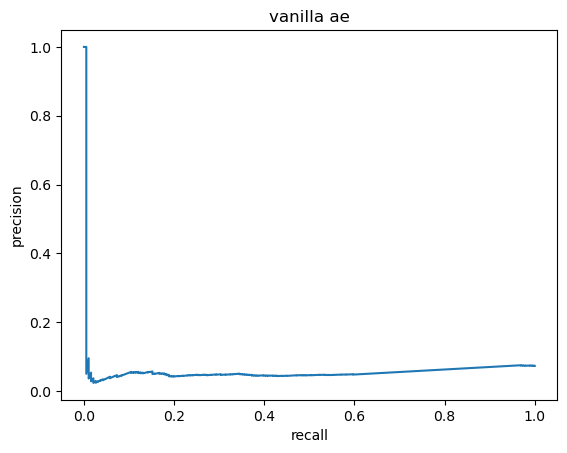

In [5]:
import sklearn.metrics as metrics

res_sorted = np.sort(res)
res_cdf = 1. * np.arange(len(res)) / (len(res) - 1)
point_color = ["red" if label == 1 else "blue" for label in y_test]
point_size = [0.1 if label == 0 else 10 for label in y_test]
# plt.hist(res, bins=200)
# plt.scatter(res, range(res.size), s=point_size, c=point_color)

fpr, tpr, _ = metrics.roc_curve(y_test, res)

precision, recall, threshold = metrics.precision_recall_curve(y_test, res)

# precision = precision[0:-3]
#
# recall = recall[0:-3]

plt.plot(recall, precision)

# print(precision, recall)

print(metrics.auc(fpr, tpr))
# print(metrics.auc(precision, recall))

# print(metrics.f1_score(test_labels, res))

# plt.scatter(res_sorted, range(res.size), s=point_size, c=point_color)
# plt.xlim(0, 150)
plt.ylabel("precision")
plt.xlabel("recall")
plt.title("vanilla ae")
plt.show()

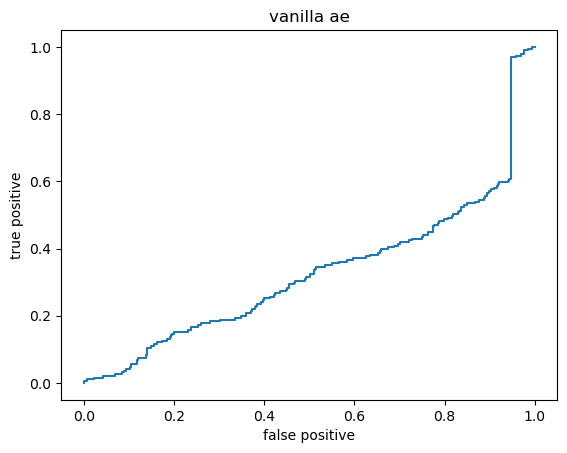

In [6]:
plt.plot(fpr, tpr)
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title("vanilla ae")
plt.show()

In [7]:
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import MACEExplainer
from omnixai.sampler.tabular import Sampler

raw_data = data_load.load_turbine_data_without_time(DATA_PATH)
# select_cols = raw_data.columns[1:2]
# raw_data = raw_data[select_cols]
raw_data['label'] = labels
feature_names = raw_data.columns.tolist()

combined_train_data = raw_data.to_numpy()

tabular_data = Tabular(
    combined_train_data,
    feature_columns=feature_names,
    target_column='label'

)

def predict_function(x):
    x = scaler.transform(x)
    print(x)
    distance = train_model.autoencoder_test(x, x, ae_model, len(x))
    res = 1 / (1 + np.exp(-(distance-65)))
    return torch.tensor([[1-n, n] for n in res])
    # return res

# print(tabular_data)

explainer = MACEExplainer(
    training_data=Sampler.subsample(tabular_data, 0.1),
    predict_function=predict_function,
)

C:\Users\sxf84\.conda\envs\windTurbineExp\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\sxf84\.conda\envs\windTurbineExp\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.

In [ ]:
test_instances = tabular_data.remove_target_column()[0:5]
explanations = explainer.explain(test_instances)
explanations.get_explanations()